https://stepik.org/lesson/1576213/step/5

In [ ]:
# @title загрузка датасета MNIST из модуля torchvision.datasets на диск
import os
import json
import torch
import torchvision
import torchvision.transforms.v2 as tfs

# Функция для реобразование изображений в формат PIL
transform = tfs.ToPILImage()

# Загрузка набора данных MNIST
mnist_train = torchvision.datasets.MNIST(r'C:\datasets\mnist', download=True, train=True)
mnist_test = torchvision.datasets.MNIST(r'C:\datasets\mnist', download=True, train=False)

# Директория для сохранения обработанных данных
dir_out = 'dataset'
file_format = 'format.json'
train_data = {'dir': "train", 'data': mnist_train}
test_data = {'dir': "test", 'data': mnist_test}

# Проверка существования директории, если её нет - создаём
if not os.path.exists(dir_out):
    os.mkdir(dir_out)  # Создание корневой папки для датасета

    for info in (train_data, test_data):
        os.mkdir(os.path.join(dir_out, info['dir']))  # Создание папок train и test

        for i in range(10):
            os.mkdir(os.path.join(dir_out, info['dir'], f"class_{i}"))  # Создание папок для каждого класса (0-9)

# Сохранение изображений в соответствующие классовые папки
for info in (train_data, test_data):
    for i in range(10):
        path = os.path.join(dir_out, info['dir'], f"class_{i}")  # Путь к папке класса
        cls = info['data'].data[info['data'].targets == i]  # Фильтрация изображений по классу

        for n, x in enumerate(cls):
            x = transform(x)  # Преобразование в PIL
            x.save(os.path.join(path, f"img_{n}.png"), "png")  # Сохранение изображения

# Создание словаря соответствий классов
targets = dict()
for i in range(10):
    targets[f'class_{i}'] = i

# Сохранение соответствий классов в JSON-файл
fp = open(os.path.join(dir_out, file_format), "w")
json.dump(targets, fp)
fp.close()

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 496kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.60MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.69MB/s]


cuda


Epoch [1/20], loss_mean_gen=6.995, loss_mean_dis=0.135: 100%|██████████| 391/391 [00:10<00:00, 37.72it/s]
Epoch [2/20], loss_mean_gen=7.126, loss_mean_dis=0.318: 100%|██████████| 391/391 [00:08<00:00, 45.56it/s]
Epoch [3/20], loss_mean_gen=5.528, loss_mean_dis=0.163: 100%|██████████| 391/391 [00:08<00:00, 45.76it/s]
Epoch [4/20], loss_mean_gen=5.994, loss_mean_dis=0.094: 100%|██████████| 391/391 [00:08<00:00, 45.08it/s]
Epoch [5/20], loss_mean_gen=5.460, loss_mean_dis=0.258: 100%|██████████| 391/391 [00:08<00:00, 44.88it/s]
Epoch [6/20], loss_mean_gen=4.575, loss_mean_dis=0.206: 100%|██████████| 391/391 [00:08<00:00, 44.96it/s]
Epoch [7/20], loss_mean_gen=4.961, loss_mean_dis=0.247: 100%|██████████| 391/391 [00:08<00:00, 44.76it/s]
Epoch [8/20], loss_mean_gen=4.469, loss_mean_dis=0.297: 100%|██████████| 391/391 [00:08<00:00, 44.24it/s]
Epoch [9/20], loss_mean_gen=3.987, loss_mean_dis=0.311: 100%|██████████| 391/391 [00:08<00:00, 43.98it/s]
Epoch [10/20], loss_mean_gen=3.563, loss_mean_

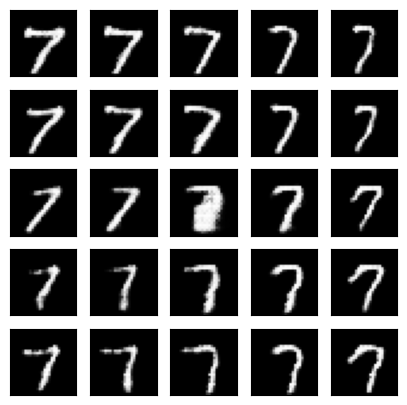

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch
import torch.utils.data as data
import torchvision
import torchvision.transforms.v2 as tfs_v2
import torch.nn as nn
import torch.optim as optim

''' 1. Загрузка и подготовка данных
       Создаётся кастомный датасет, содержащий только изображения одной выбранной цифры (target=5) из MNIST.
       Применяется трансформация (нормализация и приведение к нужному формату).
       Датасет возвращает пары (изображение, метка) — метка одна и та же (все изображения одной цифры):'''
class DigitDataset(data.Dataset):
    def __init__(self, path, train=True, target=5, transform=None):
        _dataset = torchvision.datasets.MNIST(path, download=True, train=train)
        self.dataset = _dataset.data[_dataset.targets == target]
        self.length = self.dataset.size(0)
        self.target = torch.tensor([target], dtype=torch.float32)

        if transform:
            self.dataset = transform(self.dataset).view(-1, 1, 28, 28)

    def __getitem__(self, item):
        return self.dataset[item], self.target

    def __len__(self):
        return self.length

''' 2. Определение моделей генератора и дискриминатора'''
# ГЕНЕРАТОР
# принимает вектор скрытого пространства (2D) и восстанавливает из него
# изображение (28x28) через серию линейных, сверточных и транспонированных сверточных слоев.
# Используются активации ELU, нормализация и Sigmoid на выходе для приведения значений к [0, 1].
model_gen = nn.Sequential(
    nn.Linear(2, 512*7*7, bias=False),
    nn.ELU(inplace=True),
    nn.BatchNorm1d(512*7*7),
    nn.Unflatten(1, (512, 7, 7)),
    nn.Conv2d(512, 256, 5, 1, padding='same', bias=False),
    nn.ELU(inplace=True),
    nn.BatchNorm2d(256),
    nn.Conv2d(256, 128, 5, 1, padding='same', bias=False),
    nn.ELU(inplace=True),
    nn.BatchNorm2d(128),
    nn.ConvTranspose2d(128, 64, 4, 2, padding=1, bias=False),
    nn.ELU(inplace=True),
    nn.BatchNorm2d(64),
    nn.ConvTranspose2d(64, 32, 4, 2, padding=1, bias=False),
    nn.ELU(inplace=True),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 1, 1, 1),
    nn.Sigmoid()
)

# ДИСКРИМИНАТОР
# Принимает изображение и предсказывает вероятность того, что оно настоящее (а не сгенерированное).
# Используются сверточные слои, ELU и линейный классификатор на выходе.
model_dis = nn.Sequential(
    nn.Conv2d(1, 64, 5, 2, padding=2, bias=False),
    nn.ELU(inplace=True),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 128, 5, 2, padding=2, bias=False),
    nn.ELU(inplace=True),
    nn.BatchNorm2d(128),
    nn.Flatten(),
    nn.Linear(128*7*7, 1),
)

''' 3. Настройка обучения'''
# Модели и данные отправляются на GPU, если он доступен.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model_gen.to(device)
model_dis.to(device)

epochs = 20
hidden_dim = 2
batch_size = 16

transforms = tfs_v2.Compose([tfs_v2.ToImage(), tfs_v2.ToDtype(dtype=torch.float32, scale=True)])
d_train = DigitDataset(r'C:\datasets\mnist', train=True, target=7, transform=transforms)
train_data = data.DataLoader(d_train, batch_size=batch_size, shuffle=True, drop_last=True)

# Настраиваются оптимизаторы и функция потерь (бинарная кросс-энтропия с логитами).
optimizer_gen = optim.Adam(params=model_gen.parameters(), lr=0.001)
optimizer_dis = optim.Adam(params=model_dis.parameters(), lr=0.001)
loss_func = nn.BCEWithLogitsLoss()

# Векторы меток для "фейков" и "реальных" изображений:
targets_0 = torch.zeros(batch_size, 1).to(device)
targets_1 = torch.ones(batch_size, 1).to(device)

loss_gen_lst = []
loss_dis_lst = []

model_gen.train()
model_dis.train()

''' 4. Основной цикл обучения (GAN)'''
for _e in range(epochs):
    loss_mean_gen = 0
    loss_mean_dis = 0
    lm_count = 0

    train_tqdm = tqdm(train_data, leave=True)
    for x_train, y_train in train_tqdm:
        x_train = x_train.to(device)

        ''' Обучение генератора'''
        # Генератор создает изображения из случайных векторов h.
        # Дискриминатор пытается определить, что это подделка, но генератор хочет обмануть его, поэтому цель — чтобы fake_out ≈ 1.
        h = torch.normal(mean=torch.zeros((batch_size, hidden_dim)), std=torch.ones((batch_size, hidden_dim)))
        h = h.to(device)

        img_gen = model_gen(h)
        fake_out = model_dis(img_gen)

        loss_gen = loss_func(fake_out, targets_1)

        optimizer_gen.zero_grad()
        loss_gen.backward()
        optimizer_gen.step()

        '''Обучение дискриминатора'''
        # Сравниваются предсказания дискриминатора для реальных и фейковых изображений.
        # Цель дискриминатора — правильно отличать реальные от фейков.
        img_gen = model_gen(h)
        fake_out = model_dis(img_gen)
        real_out = model_dis(x_train)

        outputs = torch.cat([real_out, fake_out], dim=0).to(device)
        targets = torch.cat([targets_1, targets_0], dim=0).to(device)

        loss_dis = loss_func(outputs, targets)

        optimizer_dis.zero_grad()
        loss_dis.backward()
        optimizer_dis.step()

        lm_count += 1
        loss_mean_gen = 1/lm_count * loss_gen.item() + (1 - 1/lm_count) * loss_mean_gen
        loss_mean_dis = 1/lm_count * loss_dis.item() + (1 - 1/lm_count) * loss_mean_dis

        train_tqdm.set_description(f"Epoch [{_e+1}/{epochs}], loss_mean_gen={loss_mean_gen:.3f}, loss_mean_dis={loss_mean_dis:.3f}")

    loss_gen_lst.append(loss_mean_gen)
    loss_dis_lst.append(loss_mean_dis)

''' 5. Сохранение результатов'''
# Сохраняются веса моделей и история потерь
st = model_gen.state_dict()
torch.save(st, 'model_gen.tar')

st = model_dis.state_dict()
torch.save(st, 'model_dis.tar')

st = {'loss_gen': loss_gen_lst, 'loss_dis': loss_dis_lst}
torch.save(st, 'model_gan_losses.tar')

# st = torch.load('model_gen.tar', weights_only=True)
# model_gen.load_state_dict(st)

''' 6. Визуализация результатов генерации'''
model_gen.eval()
n = 2
total = 2*n+1

plt.figure(figsize=(total, total))

num = 1
for i in range(-n, n+1):
  for j in range(-n, n+1):
    ax = plt.subplot(total, total, num)
    num += 1
    h = torch.tensor([[1 * i / n, 1 * j / n]], dtype=torch.float32)
    predict = model_gen(h.to(device))
    predict = predict.detach().squeeze()
    dec_img = predict.cpu().numpy()

    plt.imshow(dec_img, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()